# Advanced Time Series Analysis and Resampling

## Overview

This notebook demonstrates advanced time series analysis techniques, focusing on data resampling, interpolation, and sensor data processing. We'll work with energy consumption data and sensor measurements to explore various time series manipulation techniques.

### Key Objectives:
1. Load and process time series data with proper datetime indexing
2. Implement frequency conversion and resampling techniques
3. Apply downsampling for data aggregation
4. Perform upsampling with advanced interpolation methods
5. Process multi-sensor time series data
6. Handle missing data and irregular time intervals
7. Export processed data in multiple formats

## 1. Import Libraries and Load Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from datetime import datetime, timedelta
from pathlib import Path
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

DATA_PATH = Path('data')
OUTPUT_PATH = Path('output')
OUTPUT_PATH.mkdir(exist_ok=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load configuration parameters from data folder
with open('data/proj5_params.json') as f:
    params = json.load(f)

print("Configuration parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# Create local copy of parameters file
with open(DATA_PATH / 'proj5_params.json', 'w') as f:
    json.dump(params, f, indent=2)

print(f"\nParameters saved to {DATA_PATH / 'proj5_params.json'}")

Configuration parameters:
  original_frequency: D
  target_frequency: W
  downsample_periods: 3
  downsample_units: d
  upsample_periods: 2
  upsample_units: h
  interpolation: polynomial
  interpolation_order: 3
  sensors_periods: 10
  sensors_units: s

Parameters saved to data\proj5_params.json


## 2. Load and Explore Energy Consumption Data

In [3]:
# Load the main time series dataset
df = pd.read_csv('data/proj5_timeseries.csv')

print("Original dataset info:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)

Original dataset info:
Shape: (4385, 5)
Columns: ['Date', 'Consumption [Wh]', 'Wind', 'Solar', 'Wind+Solar']

First few rows:
         Date  Consumption [Wh]  Wind  Solar  Wind+Solar
0  2006-01-01          1069.184   NaN    NaN         NaN
1  2006-01-02          1380.521   NaN    NaN         NaN
2  2006-01-03          1442.533   NaN    NaN         NaN
3  2006-01-04          1457.217   NaN    NaN         NaN
4  2006-01-05          1477.131   NaN    NaN         NaN

Data types:
Date                 object
Consumption [Wh]    float64
Wind                float64
Solar               float64
Wind+Solar          float64
dtype: object


In [4]:
# Data preprocessing and column renaming (as in original project05.py)
df.rename(columns={
    'Date': 'date',
    'Consumption [Wh]': 'consumption__wh_',
    'Wind': 'wind',
    'Solar': 'solar',
    'Wind+Solar': 'wind_solar'
}, inplace=True)

print("Renamed columns:")
print(list(df.columns))

Renamed columns:
['date', 'consumption__wh_', 'wind', 'solar', 'wind_solar']


In [5]:
# Convert to datetime and set as index
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format='mixed')
df.set_index(df.columns[0], inplace=True)
df.index = df.index.infer_objects()

print("After datetime conversion:")
print(f"Index type: {type(df.index)}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Number of days: {(df.index.max() - df.index.min()).days}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nBasic statistics:")
print(df.describe())

After datetime conversion:
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Date range: 2006-01-01 00:00:00 to 2017-12-31 00:00:00
Number of days: 4382

Data types:
consumption__wh_    float64
wind                float64
solar               float64
wind_solar          float64
dtype: object

Basic statistics:
       consumption__wh_         wind        solar   wind_solar
count       4383.000000  2920.000000  2188.000000  2187.000000
mean        1338.675836   164.814173    89.258695   272.663481
std          165.775710   143.692732    58.550099   146.319884
min          842.395000     5.757000     1.968000    21.478000
25%         1217.859000    62.353250    35.179250   172.185500
50%         1367.123000   119.098000    86.407000   240.991000
75%         1457.761000   217.900250   135.071500   338.988000
max         1709.568000   826.278000   241.580000   851.556000


In [6]:
# Set frequency and save initial processing (as in original project05.py)
original_frequency = params['original_frequency']
df = df.asfreq(original_frequency)

print(f"Set frequency to: {original_frequency}")
print(f"DataFrame frequency: {df.index.freq}")

# Save processed data (as in original)
df.to_pickle(DATA_PATH / 'proj5_ex01.pkl')
df.to_csv(OUTPUT_PATH / 'proj5vvv_ex01.csv')

print(f"Initial processed data saved as {DATA_PATH / 'proj5_ex01.pkl'} and {OUTPUT_PATH / 'proj5vvv_ex01.csv'}")

Set frequency to: D
DataFrame frequency: <Day>
Initial processed data saved as data\proj5_ex01.pkl and output\proj5vvv_ex01.csv


## 3. Data Visualization

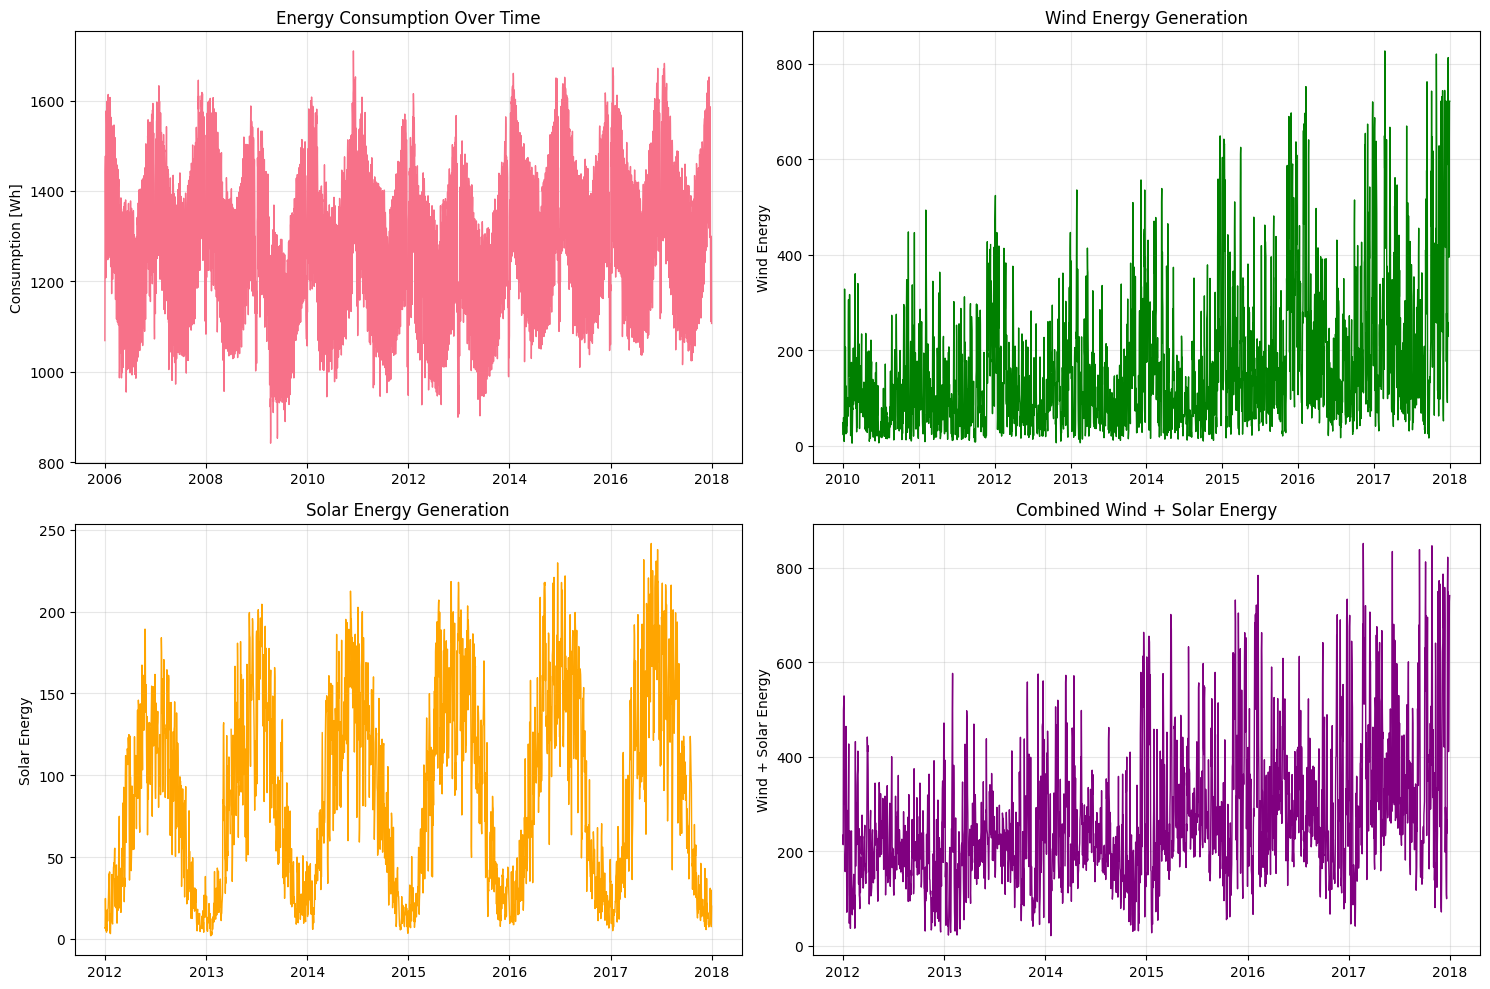

In [7]:
# Visualize the time series data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Consumption data
axes[0, 0].plot(df.index, df['consumption__wh_'], linewidth=1)
axes[0, 0].set_title('Energy Consumption Over Time')
axes[0, 0].set_ylabel('Consumption [Wh]')
axes[0, 0].grid(True, alpha=0.3)

# Wind energy
axes[0, 1].plot(df.index, df['wind'], color='green', linewidth=1)
axes[0, 1].set_title('Wind Energy Generation')
axes[0, 1].set_ylabel('Wind Energy')
axes[0, 1].grid(True, alpha=0.3)

# Solar energy
axes[1, 0].plot(df.index, df['solar'], color='orange', linewidth=1)
axes[1, 0].set_title('Solar Energy Generation')
axes[1, 0].set_ylabel('Solar Energy')
axes[1, 0].grid(True, alpha=0.3)

# Combined renewable
axes[1, 1].plot(df.index, df['wind_solar'], color='purple', linewidth=1)
axes[1, 1].set_title('Combined Wind + Solar Energy')
axes[1, 1].set_ylabel('Wind + Solar Energy')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'energy_timeseries_overview.png', dpi=300, bbox_inches='tight')
plt.show()

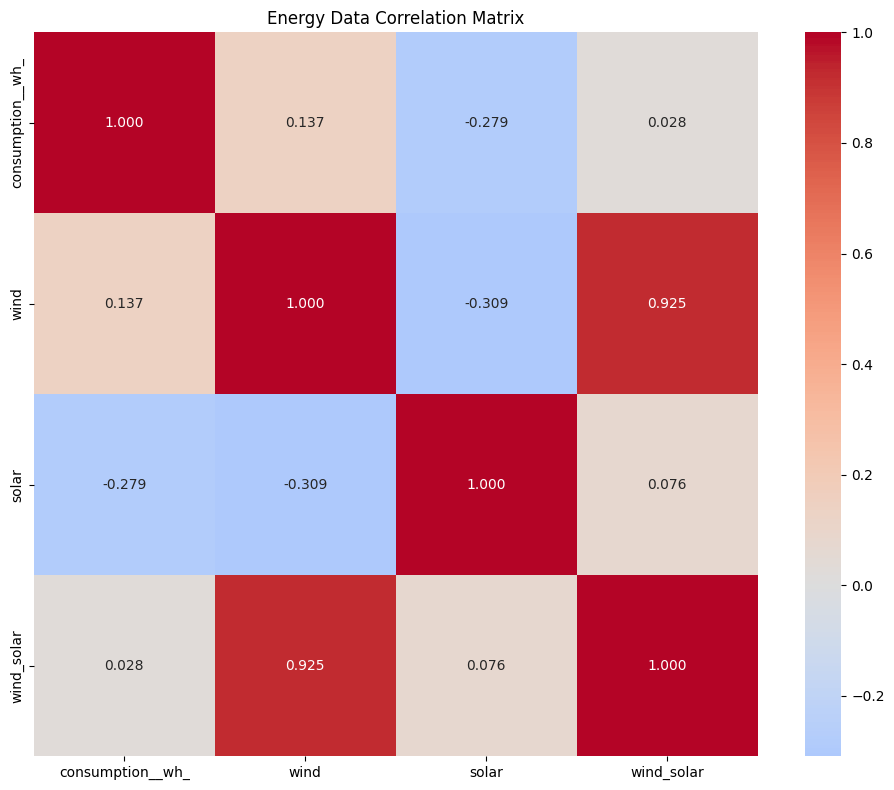

Key correlations:
consumption__wh_ vs wind: 0.137
consumption__wh_ vs solar: -0.279
consumption__wh_ vs wind_solar: 0.028
wind vs solar: -0.309
wind vs wind_solar: 0.925
solar vs wind_solar: 0.076


In [8]:
# Correlation analysis
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Energy Data Correlation Matrix')
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'energy_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Key correlations:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        print(f"{correlation_matrix.columns[i]} vs {correlation_matrix.columns[j]}: {corr_val:.3f}")

## 4. Frequency Conversion

In [9]:
# Convert to target frequency (as in original project05.py)
target_frequency = params['target_frequency']
df_2 = df.asfreq(target_frequency)

print(f"Original frequency: {original_frequency}")
print(f"Target frequency: {target_frequency}")
print(f"\nOriginal data shape: {df.shape}")
print(f"Converted data shape: {df_2.shape}")
print(f"\nData reduction factor: {df.shape[0] / df_2.shape[0]:.2f}")

# Save frequency converted data (as in original)
df_2.to_pickle(DATA_PATH / 'proj5_ex02.pkl')
df_2.to_csv(OUTPUT_PATH / 'proj5vvv_ex02.csv')

print(f"\nFrequency converted data saved as {DATA_PATH / 'proj5_ex02.pkl'} and {OUTPUT_PATH / 'proj5vvv_ex02.csv'}")

Original frequency: D
Target frequency: W

Original data shape: (4383, 4)
Converted data shape: (627, 4)

Data reduction factor: 6.99

Frequency converted data saved as data\proj5_ex02.pkl and output\proj5vvv_ex02.csv


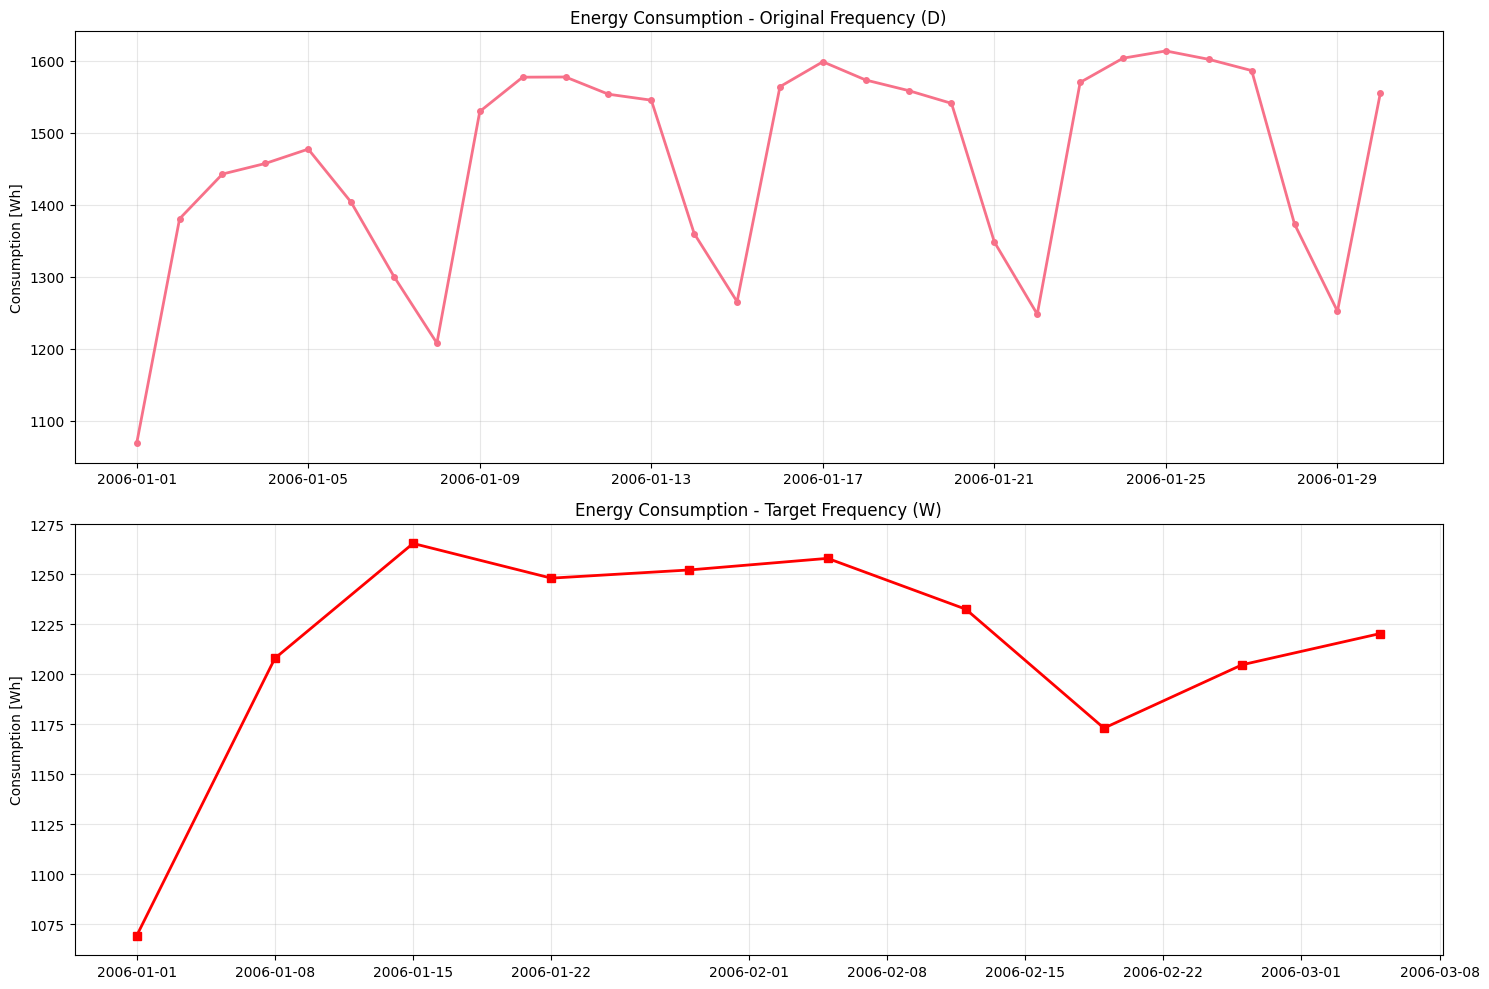

In [10]:
# Visualize frequency conversion effects
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Original frequency
sample_period = df.index[:30]  # First 30 periods
axes[0].plot(sample_period, df.loc[sample_period, 'consumption__wh_'], 'o-', linewidth=2, markersize=4)
axes[0].set_title(f'Energy Consumption - Original Frequency ({original_frequency})')
axes[0].set_ylabel('Consumption [Wh]')
axes[0].grid(True, alpha=0.3)

# Target frequency
sample_period_2 = df_2.index[:10]  # First 10 periods of converted data
axes[1].plot(sample_period_2, df_2.loc[sample_period_2, 'consumption__wh_'], 's-', 
             linewidth=2, markersize=6, color='red')
axes[1].set_title(f'Energy Consumption - Target Frequency ({target_frequency})')
axes[1].set_ylabel('Consumption [Wh]')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'frequency_conversion_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Downsampling with Aggregation

In [11]:
# Downsampling parameters (as in original project05.py)
downsample_periods = params['downsample_periods']
downsample_units = params['downsample_units']
downsample_rule = f'{downsample_periods}{downsample_units}'

print(f"Downsampling rule: {downsample_rule}")
print(f"This means: every {downsample_periods} {downsample_units}")

# Perform downsampling with sum aggregation
df_downsampled = df.resample(downsample_rule).sum(min_count=downsample_periods)

print(f"\nOriginal data points: {len(df)}")
print(f"Downsampled data points: {len(df_downsampled)}")
print(f"Compression ratio: {len(df) / len(df_downsampled):.2f}")

# Save downsampled data (as in original)
df_downsampled.to_csv(OUTPUT_PATH / 'proj5vvv_ex03.csv')
df_downsampled.to_pickle(DATA_PATH / 'proj5_ex03.pkl')

print(f"\nDownsampled data saved as {DATA_PATH / 'proj5_ex03.pkl'} and {OUTPUT_PATH / 'proj5vvv_ex03.csv'}")

Downsampling rule: 3d
This means: every 3 d

Original data points: 4383
Downsampled data points: 1461
Compression ratio: 3.00

Downsampled data saved as data\proj5_ex03.pkl and output\proj5vvv_ex03.csv


In [12]:
# Analyze downsampling effects
print("Downsampling analysis:")
print(f"Original data statistics:")
print(df['consumption__wh_'].describe())

print(f"\nDownsampled data statistics:")
print(df_downsampled['consumption__wh_'].describe())

# Calculate information loss
original_variance = df['consumption__wh_'].var()
downsampled_variance = df_downsampled['consumption__wh_'].var()
variance_retention = downsampled_variance / original_variance

print(f"\nVariance retention: {variance_retention:.3f} ({variance_retention*100:.1f}%)")

Downsampling analysis:
Original data statistics:
count    4383.000000
mean     1338.675836
std       165.775710
min       842.395000
25%      1217.859000
50%      1367.123000
75%      1457.761000
max      1709.568000
Name: consumption__wh_, dtype: float64

Downsampled data statistics:
count    1461.000000
mean     4016.027507
std       397.480818
min      2705.168000
25%      3728.170000
50%      4027.334000
75%      4296.008000
max      5015.700000
Name: consumption__wh_, dtype: float64

Variance retention: 5.749 (574.9%)


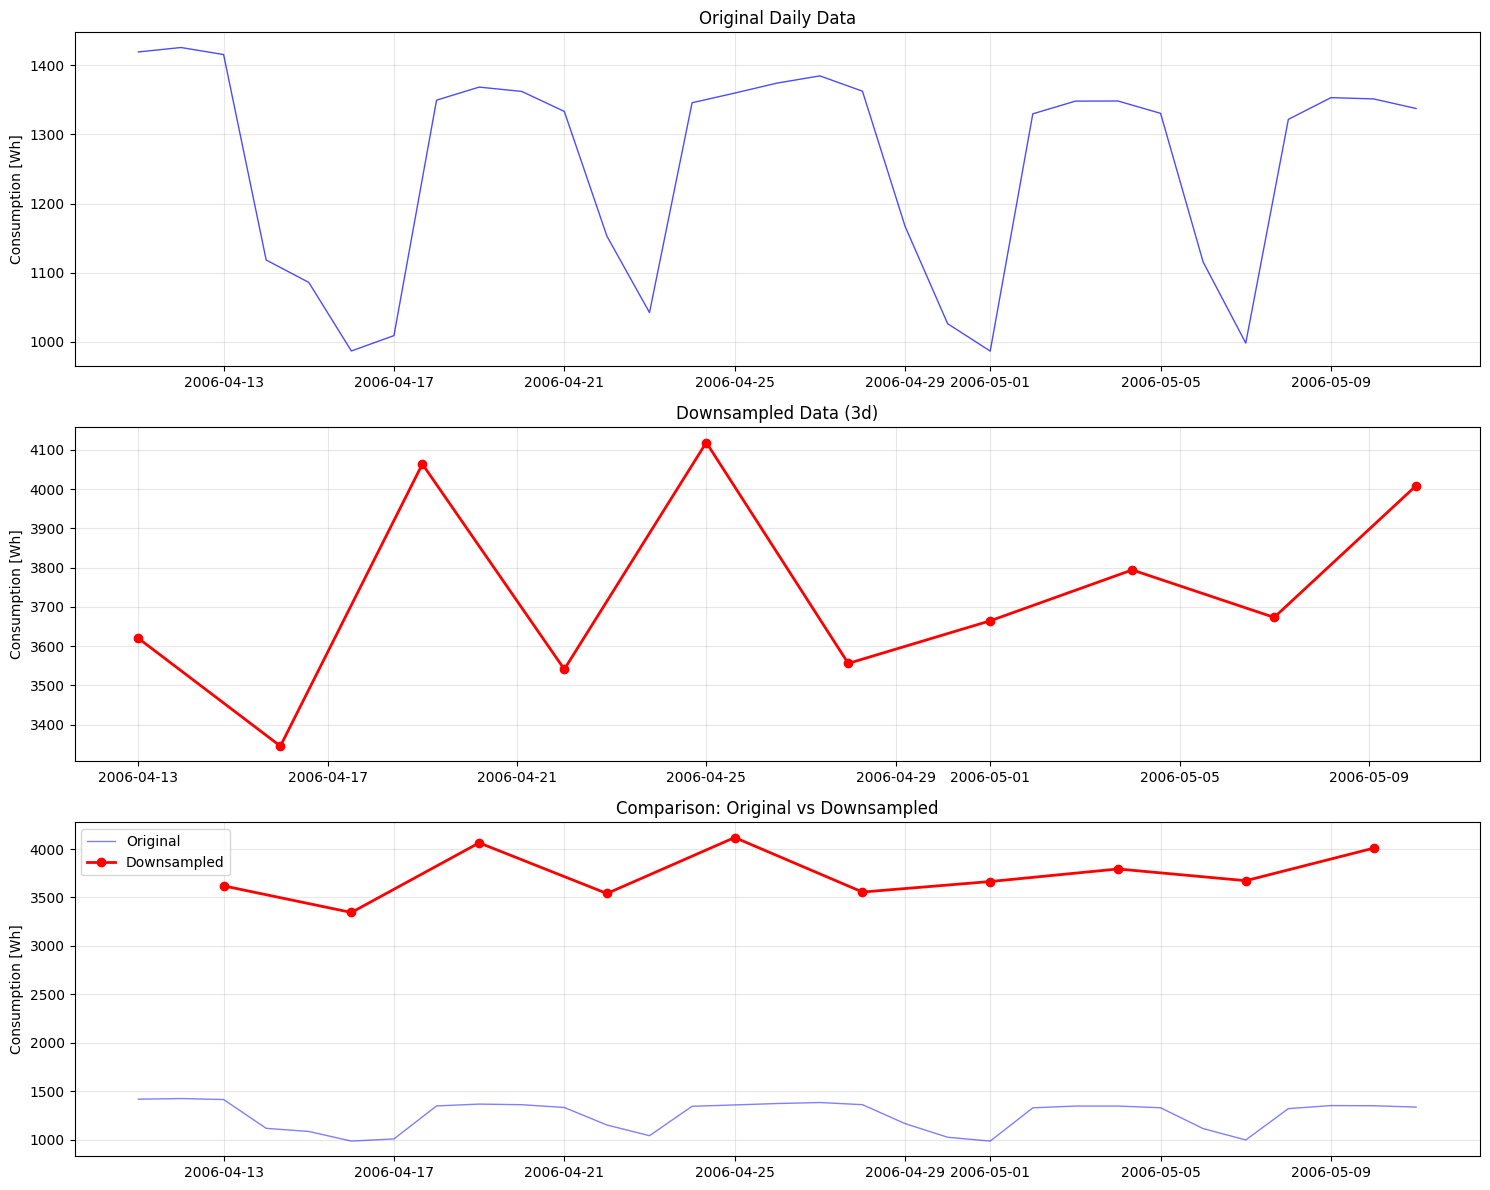

In [13]:
# Visualize downsampling effects
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Select a representative period for comparison
start_date = df.index[100]
end_date = start_date + pd.Timedelta(days=30)
mask = (df.index >= start_date) & (df.index <= end_date)
mask_ds = (df_downsampled.index >= start_date) & (df_downsampled.index <= end_date)

# Original data
axes[0].plot(df.index[mask], df.loc[mask, 'consumption__wh_'], 'b-', linewidth=1, alpha=0.7)
axes[0].set_title('Original Daily Data')
axes[0].set_ylabel('Consumption [Wh]')
axes[0].grid(True, alpha=0.3)

# Downsampled data
axes[1].plot(df_downsampled.index[mask_ds], df_downsampled.loc[mask_ds, 'consumption__wh_'], 
             'ro-', linewidth=2, markersize=6)
axes[1].set_title(f'Downsampled Data ({downsample_rule})')
axes[1].set_ylabel('Consumption [Wh]')
axes[1].grid(True, alpha=0.3)

# Overlay comparison
axes[2].plot(df.index[mask], df.loc[mask, 'consumption__wh_'], 'b-', linewidth=1, alpha=0.5, label='Original')
axes[2].plot(df_downsampled.index[mask_ds], df_downsampled.loc[mask_ds, 'consumption__wh_'], 
             'ro-', linewidth=2, markersize=6, label='Downsampled')
axes[2].set_title('Comparison: Original vs Downsampled')
axes[2].set_ylabel('Consumption [Wh]')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'downsampling_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Upsampling with Advanced Interpolation

In [14]:
# Upsampling parameters (as in original project05.py)
upsample_periods = params['upsample_periods']
upsample_units = params['upsample_units']
upsample_rule = f'{upsample_periods}{upsample_units}'
interpolation = params['interpolation']
interpolation_order = params['interpolation_order']

print(f"Upsampling parameters:")
print(f"  Rule: {upsample_rule}")
print(f"  Interpolation method: {interpolation}")
print(f"  Interpolation order: {interpolation_order}")

# Perform upsampling with interpolation
df_upsampled = df.resample(upsample_rule).interpolate(method=interpolation, order=interpolation_order)

print(f"\nOriginal data points: {len(df)}")
print(f"Upsampled data points: {len(df_upsampled)}")
print(f"Expansion ratio: {len(df_upsampled) / len(df):.2f}")

Upsampling parameters:
  Rule: 2h
  Interpolation method: polynomial
  Interpolation order: 3

Original data points: 4383
Upsampled data points: 52585
Expansion ratio: 12.00


In [15]:
# Scale adjustment for energy conservation (as in original project05.py)
scale_factor = pd.Timedelta(1, original_frequency) / pd.Timedelta(f'{upsample_periods}{upsample_units}')
df_upsampled = df_upsampled / scale_factor

print(f"Scale factor applied: {scale_factor}")
print(f"This ensures energy conservation during upsampling")

# Save upsampled data (as in original)
df_upsampled.to_pickle(DATA_PATH / 'proj5_ex04.pkl')
df_upsampled.to_csv(OUTPUT_PATH / 'proj5vvv_ex04.csv')

print(f"\nUpsampled data saved as {DATA_PATH / 'proj5_ex04.pkl'} and {OUTPUT_PATH / 'proj5vvv_ex04.csv'}")

Scale factor applied: 12.0
This ensures energy conservation during upsampling

Upsampled data saved as data\proj5_ex04.pkl and output\proj5vvv_ex04.csv

Upsampled data saved as data\proj5_ex04.pkl and output\proj5vvv_ex04.csv


Original sample period: 2006-02-20 00:00:00 to 2006-02-24 00:00:00
Original points: 5
Upsampled points: 49


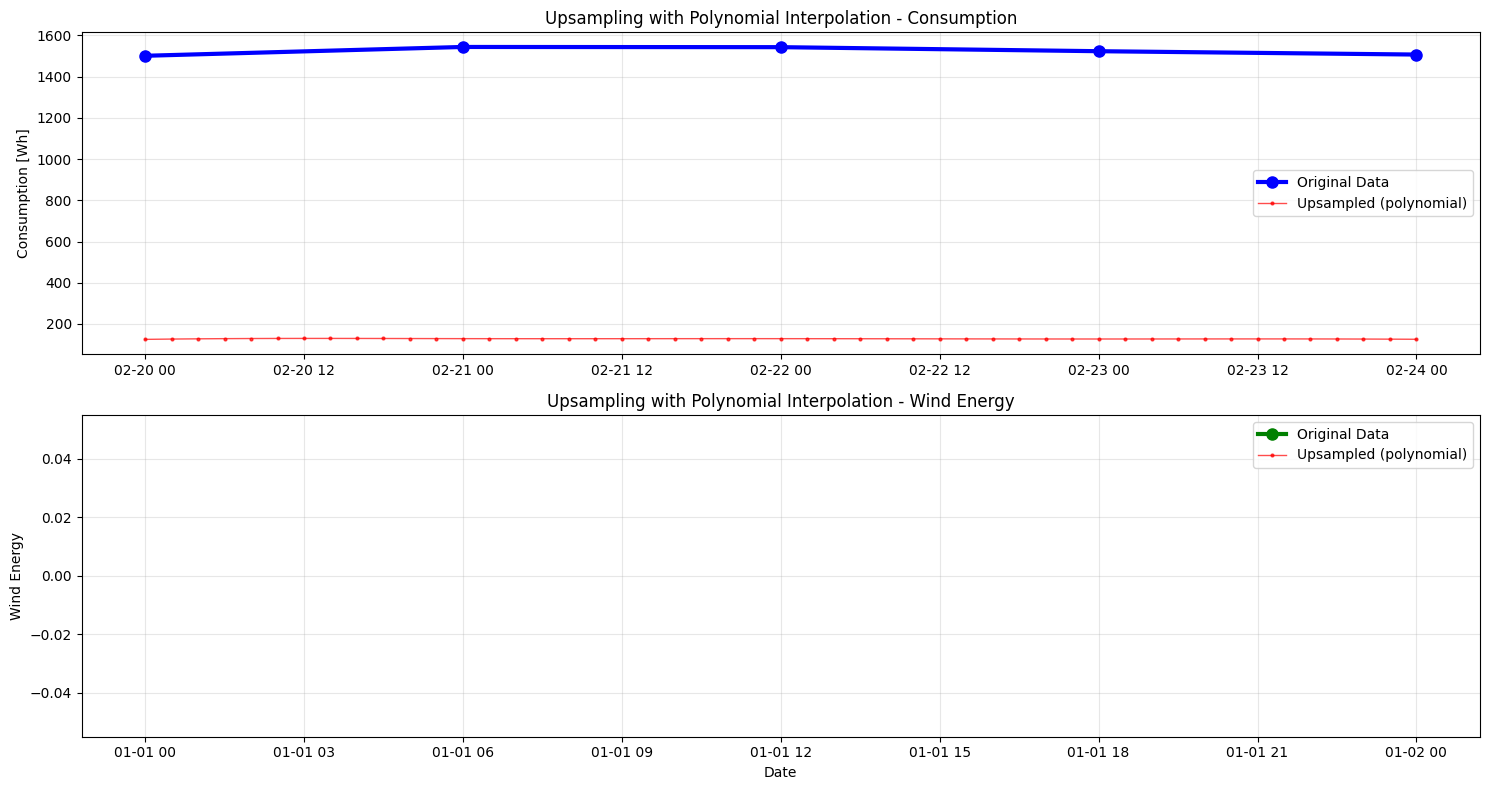

In [16]:
# Analyze upsampling quality
# Select a small period for detailed analysis
start_idx = 50
end_idx = 55
original_sample = df.iloc[start_idx:end_idx]

# Find corresponding upsampled period
start_time = original_sample.index[0]
end_time = original_sample.index[-1]
upsampled_sample = df_upsampled[(df_upsampled.index >= start_time) & (df_upsampled.index <= end_time)]

print(f"Original sample period: {start_time} to {end_time}")
print(f"Original points: {len(original_sample)}")
print(f"Upsampled points: {len(upsampled_sample)}")

# Visualize interpolation quality
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(original_sample.index, original_sample['consumption__wh_'], 'bo-', 
         linewidth=3, markersize=8, label='Original Data')
plt.plot(upsampled_sample.index, upsampled_sample['consumption__wh_'], 'r.-', 
         linewidth=1, markersize=4, alpha=0.7, label=f'Upsampled ({interpolation})')
plt.title('Upsampling with Polynomial Interpolation - Consumption')
plt.ylabel('Consumption [Wh]')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(original_sample.index, original_sample['wind'], 'go-', 
         linewidth=3, markersize=8, label='Original Data')
plt.plot(upsampled_sample.index, upsampled_sample['wind'], 'r.-', 
         linewidth=1, markersize=4, alpha=0.7, label=f'Upsampled ({interpolation})')
plt.title('Upsampling with Polynomial Interpolation - Wind Energy')
plt.ylabel('Wind Energy')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'upsampling_interpolation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Multi-Sensor Data Processing

In [17]:
# Load sensor data (as in original project05.py)
sensors_df = pd.read_pickle('data/proj5_sensors.pkl')

print("Sensor data overview:")
print(f"Shape: {sensors_df.shape}")
print(f"Columns: {list(sensors_df.columns)}")
print(f"\nFirst few rows:")
print(sensors_df.head())

print(f"\nUnique devices: {sensors_df['device_id'].nunique()}")
print(f"Device IDs: {sorted(sensors_df['device_id'].unique())}")
print(f"Total measurements: {len(sensors_df)}")

Sensor data overview:
Shape: (97920, 2)
Columns: ['device_id', 'value']

First few rows:
                     device_id    value
timestamp                              
2022-11-25 00:00:25         25  6.69375
2022-11-25 00:01:25         25  6.72500
2022-11-25 00:02:25         25  6.75625
2022-11-25 00:03:25         25  6.78750
2022-11-25 00:04:25         25  6.81875

Unique devices: 23
Device IDs: [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Total measurements: 97920


In [18]:
# Pivot table transformation (as in original project05.py)
sensors_pivot = sensors_df.pivot_table(index='timestamp', columns='device_id', values='value')

print("After pivot table transformation:")
print(f"Shape: {sensors_pivot.shape}")
print(f"Columns (devices): {list(sensors_pivot.columns)}")
print(f"\nFirst few rows:")
print(sensors_pivot.head())

print(f"\nMissing data per device:")
missing_data = sensors_pivot.isnull().sum()
for device, missing_count in missing_data.items():
    missing_pct = (missing_count / len(sensors_pivot)) * 100
    print(f"  {device}: {missing_count} ({missing_pct:.1f}%)")

After pivot table transformation:
Shape: (97920, 23)
Columns (devices): [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]

First few rows:
device_id            25  26  27   28  29  30  31  32  33  34  ...  38   39  \
timestamp                                                     ...            
2022-11-25 00:00:03 NaN NaN NaN  NaN NaN NaN NaN NaN NaN NaN  ... NaN  6.5   
2022-11-25 00:00:04 NaN NaN NaN  5.6 NaN NaN NaN NaN NaN NaN  ... NaN  NaN   
2022-11-25 00:00:08 NaN NaN NaN  NaN NaN NaN NaN NaN NaN NaN  ... NaN  NaN   
2022-11-25 00:00:09 NaN NaN NaN  NaN NaN NaN NaN NaN NaN NaN  ... NaN  NaN   
2022-11-25 00:00:12 NaN NaN NaN  NaN NaN NaN NaN NaN NaN NaN  ... NaN  NaN   

device_id            40  41   42  43  44  45  46  47  
timestamp                                             
2022-11-25 00:00:03 NaN NaN  NaN NaN NaN NaN NaN NaN  
2022-11-25 00:00:04 NaN NaN  NaN NaN NaN NaN NaN NaN  
2022-11-25 00:00:08 NaN NaN  NaN NaN NaN NaN NaN Na

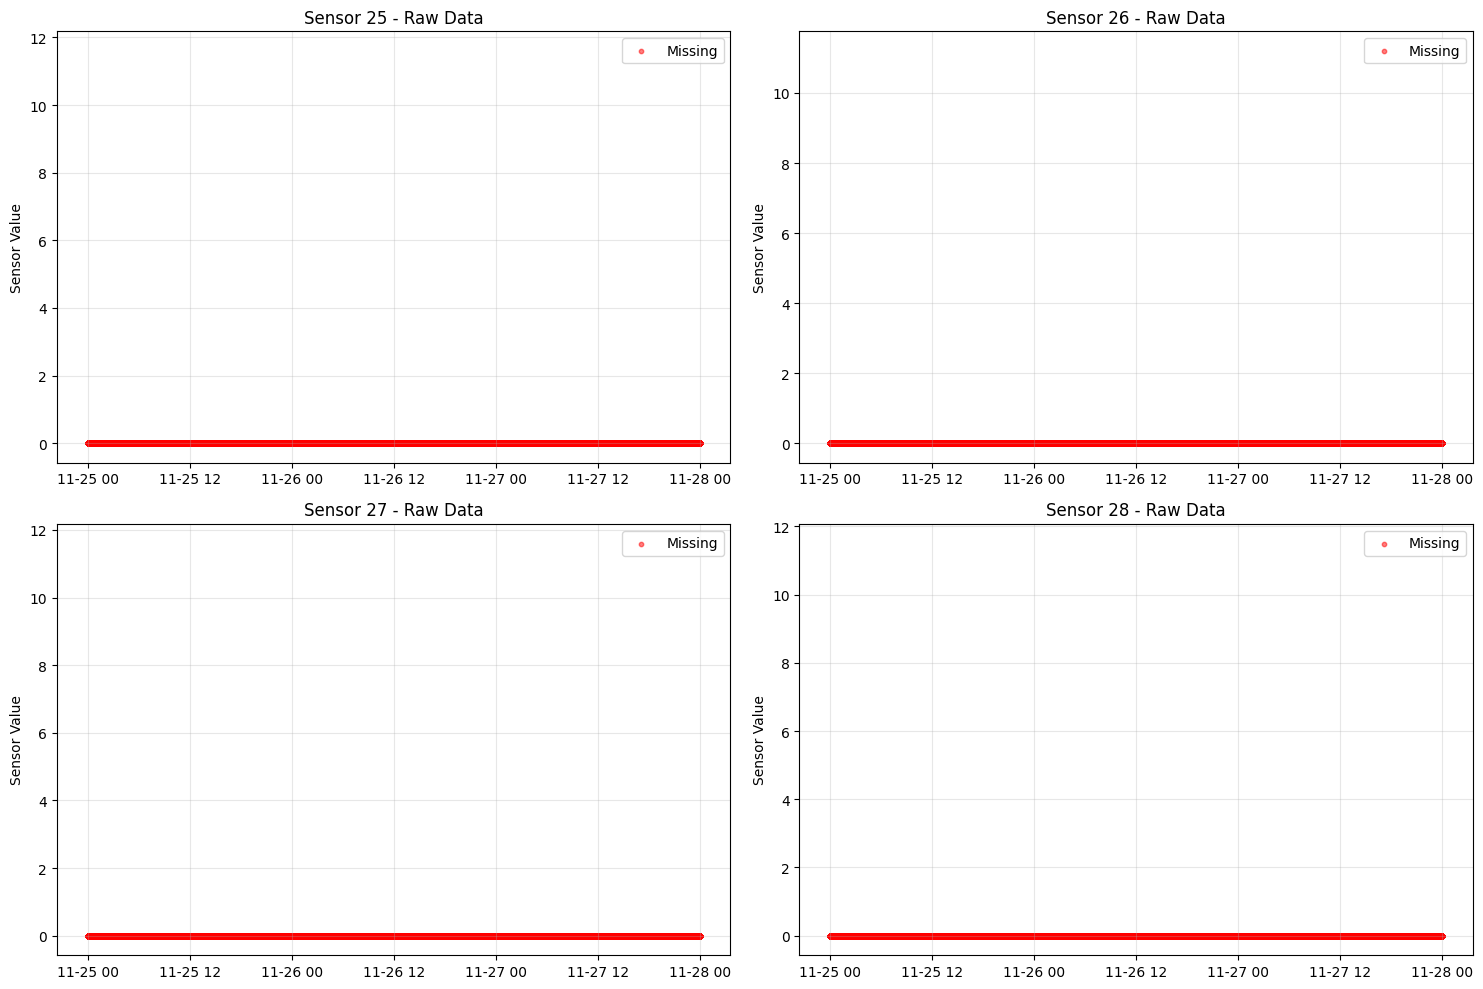

In [19]:
# Visualize sensor data before processing
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, device in enumerate(sensors_pivot.columns[:4]):  # Plot first 4 devices
    axes[i].plot(sensors_pivot.index, sensors_pivot[device], linewidth=1, alpha=0.7)
    axes[i].set_title(f'Sensor {device} - Raw Data')
    axes[i].set_ylabel('Sensor Value')
    axes[i].grid(True, alpha=0.3)
    
    # Highlight missing data
    missing_mask = sensors_pivot[device].isnull()
    if missing_mask.any():
        axes[i].scatter(sensors_pivot.index[missing_mask], 
                       [0] * missing_mask.sum(), 
                       color='red', s=10, alpha=0.5, label='Missing')
        axes[i].legend()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'sensor_data_raw.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Resample and interpolate sensor data (as in original project05.py)
sensors_resample_rule = f"{params['sensors_periods']}{params['sensors_units']}"
print(f"Sensor resampling rule: {sensors_resample_rule}")

sensors_processed = sensors_pivot.resample(sensors_resample_rule).mean().interpolate(method='linear')
sensors_processed = sensors_processed.dropna()

print(f"\nOriginal sensor data points: {len(sensors_pivot)}")
print(f"Processed sensor data points: {len(sensors_processed)}")
print(f"Data reduction factor: {len(sensors_pivot) / len(sensors_processed):.2f}")

print(f"\nMissing data after processing:")
missing_after = sensors_processed.isnull().sum()
for device, missing_count in missing_after.items():
    print(f"  {device}: {missing_count}")

# Save processed sensor data (as in original)
sensors_processed.to_csv(OUTPUT_PATH / 'proj5vvv_ex05.csv')
sensors_processed.to_pickle(DATA_PATH / 'proj5_ex05.pkl')

print("\nProcessed sensor data saved as proj5_ex05.pkl and proj5vvv_ex05.csv")

Sensor resampling rule: 10s

Original sensor data points: 97920
Processed sensor data points: 25915
Data reduction factor: 3.78

Missing data after processing:
  25: 0
  26: 0
  27: 0
  28: 0
  29: 0
  30: 0
  31: 0
  32: 0
  33: 0
  34: 0
  35: 0
  36: 0
  37: 0
  38: 0
  39: 0
  40: 0
  41: 0
  42: 0
  43: 0
  44: 0
  45: 0
  46: 0
  47: 0

Processed sensor data saved as proj5_ex05.pkl and proj5vvv_ex05.csv

Processed sensor data saved as proj5_ex05.pkl and proj5vvv_ex05.csv


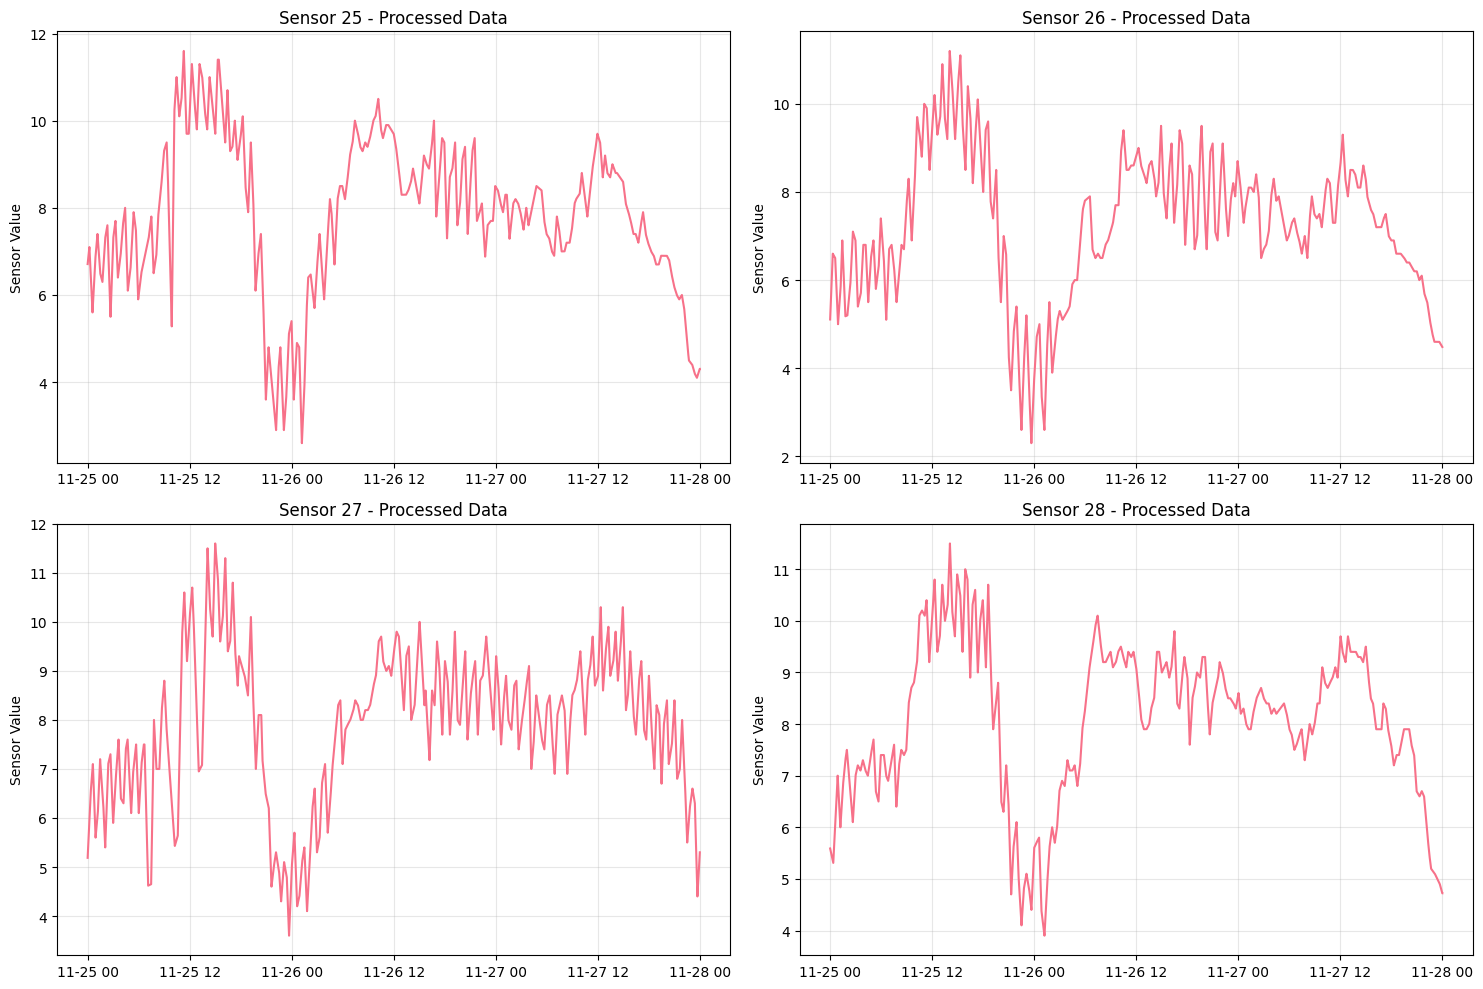

In [21]:
# Visualize processed sensor data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, device in enumerate(sensors_processed.columns[:4]):
    axes[i].plot(sensors_processed.index, sensors_processed[device], linewidth=1.5)
    axes[i].set_title(f'Sensor {device} - Processed Data')
    axes[i].set_ylabel('Sensor Value')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'sensor_data_processed.png', dpi=300, bbox_inches='tight')
plt.show()

Sensor data statistics:
device_id            25            26            27            28  \
count      25915.000000  25915.000000  25915.000000  25915.000000   
mean           7.863802      7.259333      7.900730      8.080802   
std            1.714507      1.578735      1.468122      1.461217   
min            2.600000      2.300000      3.600000      3.900000   
25%            6.918899      6.400000      7.033966      7.191667   
50%            7.989474      7.371429      8.127703      8.294737   
75%            9.092982      8.348148      8.933333      9.193317   
max           11.600000     11.200000     11.600000     11.500000   

device_id            29            30            31            32  \
count      25915.000000  25915.000000  25915.000000  25915.000000   
mean           8.798978      8.022740      6.752845      8.573949   
std            1.350787      1.352854      1.149758      1.478082   
min            5.500000      3.900000      4.430000      3.900000   
25%      

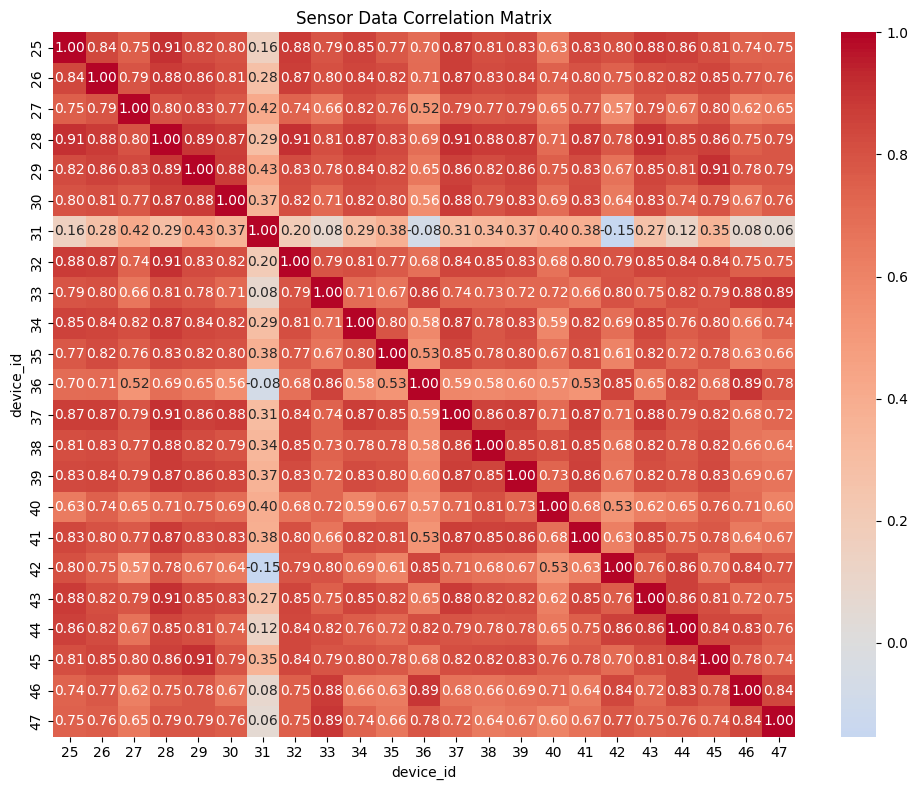


Highly correlated sensor pairs (|correlation| > 0.7):
  25 vs 26: 0.840
  25 vs 27: 0.750
  25 vs 28: 0.908
  25 vs 29: 0.821
  25 vs 30: 0.799
  25 vs 32: 0.876
  25 vs 33: 0.794
  25 vs 34: 0.853
  25 vs 35: 0.773
  25 vs 36: 0.702
  25 vs 37: 0.868
  25 vs 38: 0.814
  25 vs 39: 0.830
  25 vs 41: 0.835
  25 vs 42: 0.802
  25 vs 43: 0.883
  25 vs 44: 0.863
  25 vs 45: 0.813
  25 vs 46: 0.740
  25 vs 47: 0.747
  26 vs 27: 0.794
  26 vs 28: 0.881
  26 vs 29: 0.855
  26 vs 30: 0.812
  26 vs 32: 0.868
  26 vs 33: 0.804
  26 vs 34: 0.844
  26 vs 35: 0.822
  26 vs 36: 0.707
  26 vs 37: 0.868
  26 vs 38: 0.828
  26 vs 39: 0.838
  26 vs 40: 0.744
  26 vs 41: 0.801
  26 vs 42: 0.746
  26 vs 43: 0.819
  26 vs 44: 0.820
  26 vs 45: 0.846
  26 vs 46: 0.772
  26 vs 47: 0.761
  27 vs 28: 0.801
  27 vs 29: 0.833
  27 vs 30: 0.771
  27 vs 32: 0.735
  27 vs 34: 0.818
  27 vs 35: 0.760
  27 vs 37: 0.790
  27 vs 38: 0.773
  27 vs 39: 0.792
  27 vs 41: 0.769
  27 vs 43: 0.788
  27 vs 45: 0.798
  28 vs 2

In [22]:
# Sensor data statistical analysis
print("Sensor data statistics:")
print(sensors_processed.describe())

# Correlation analysis between sensors
plt.figure(figsize=(10, 8))
sensor_corr = sensors_processed.corr()
sns.heatmap(sensor_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Sensor Data Correlation Matrix')
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'sensor_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Find highly correlated sensor pairs
print("\nHighly correlated sensor pairs (|correlation| > 0.7):")
for i in range(len(sensor_corr.columns)):
    for j in range(i+1, len(sensor_corr.columns)):
        corr_val = sensor_corr.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"  {sensor_corr.columns[i]} vs {sensor_corr.columns[j]}: {corr_val:.3f}")

## 8. Comprehensive Analysis and Comparison

In [23]:
# Compare all processing stages
processing_summary = {
    'Stage': [
        'Original Data',
        'Frequency Converted', 
        'Downsampled',
        'Upsampled',
        'Sensor Data (Original)',
        'Sensor Data (Processed)'
    ],
    'Data Points': [
        len(df),
        len(df_2),
        len(df_downsampled),
        len(df_upsampled),
        len(sensors_pivot),
        len(sensors_processed)
    ],
    'Frequency/Rule': [
        original_frequency,
        target_frequency,
        downsample_rule,
        upsample_rule,
        'Irregular',
        sensors_resample_rule
    ],
    'File Saved': [
        'proj5_ex01.pkl',
        'proj5_ex02.pkl',
        'proj5_ex03.pkl',
        'proj5_ex04.pkl',
        'Raw sensor data',
        'proj5_ex05.pkl'
    ]
}

summary_df = pd.DataFrame(processing_summary)
print("Processing Summary:")
print("=" * 80)
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(OUTPUT_PATH / 'processing_summary.csv', index=False)
print("\nProcessing summary saved to processing_summary.csv")

Processing Summary:
                  Stage  Data Points Frequency/Rule      File Saved
          Original Data         4383              D  proj5_ex01.pkl
    Frequency Converted          627              W  proj5_ex02.pkl
            Downsampled         1461             3d  proj5_ex03.pkl
              Upsampled        52585             2h  proj5_ex04.pkl
 Sensor Data (Original)        97920      Irregular Raw sensor data
Sensor Data (Processed)        25915            10s  proj5_ex05.pkl

Processing summary saved to processing_summary.csv


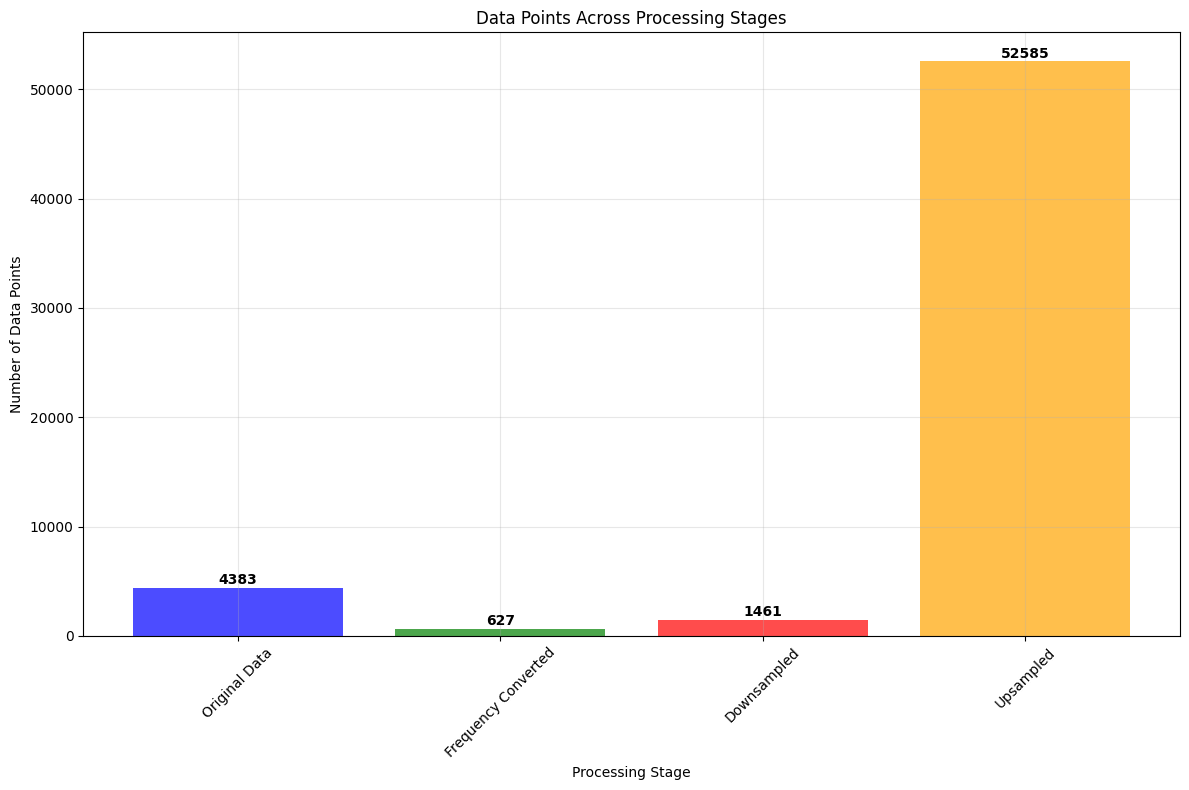

In [24]:
# Data size comparison visualization
plt.figure(figsize=(12, 8))

# Exclude sensor data for cleaner comparison
energy_stages = summary_df.iloc[:4]

bars = plt.bar(energy_stages['Stage'], energy_stages['Data Points'], 
               color=['blue', 'green', 'red', 'orange'], alpha=0.7)

plt.title('Data Points Across Processing Stages')
plt.ylabel('Number of Data Points')
plt.xlabel('Processing Stage')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, energy_stages['Data Points']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'processing_stages_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Advanced Time Series Analysis

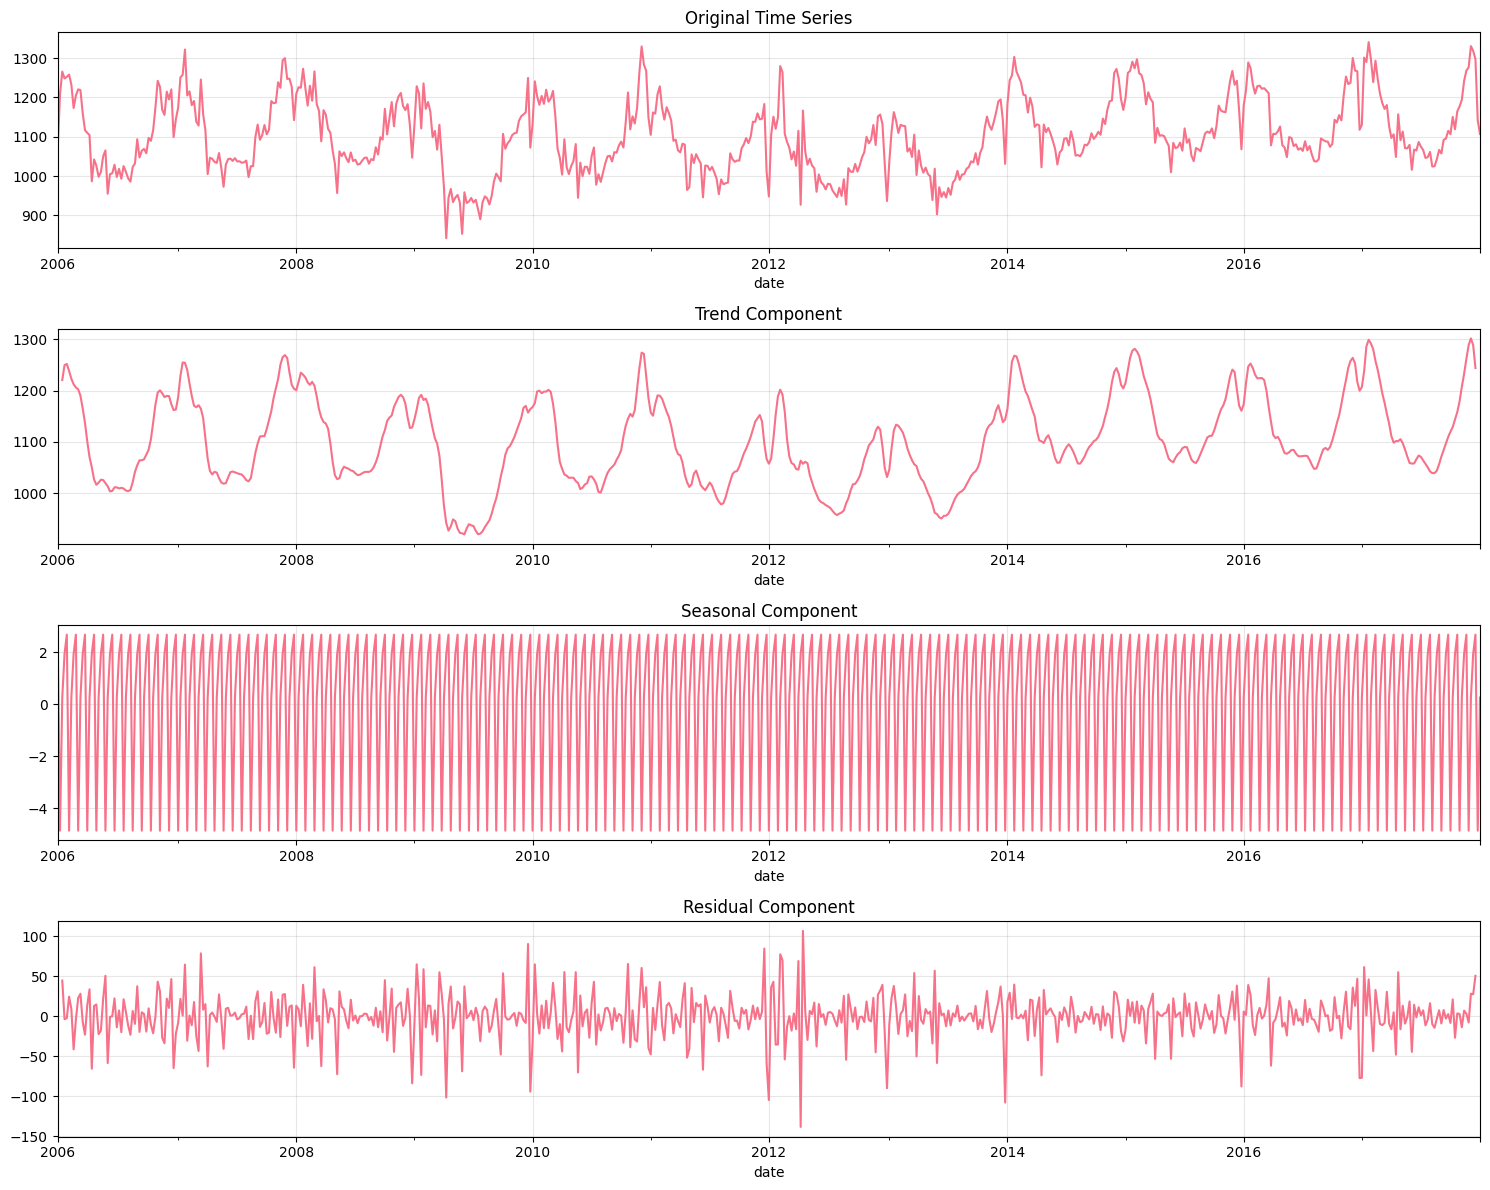

Seasonal decomposition completed


In [25]:
# Seasonal decomposition analysis
from statsmodels.tsa.seasonal import seasonal_decompose

# Use weekly data for cleaner decomposition
weekly_data = df_2['consumption__wh_'].dropna()

if len(weekly_data) > 20:  # Need sufficient data for decomposition
    decomposition = seasonal_decompose(weekly_data, model='additive', period=4)  # Assume monthly seasonality
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    decomposition.observed.plot(ax=axes[0], title='Original Time Series')
    decomposition.trend.plot(ax=axes[1], title='Trend Component')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
    decomposition.resid.plot(ax=axes[3], title='Residual Component')
    
    for ax in axes:
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'seasonal_decomposition.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Seasonal decomposition completed")
else:
    print("Insufficient data for seasonal decomposition")

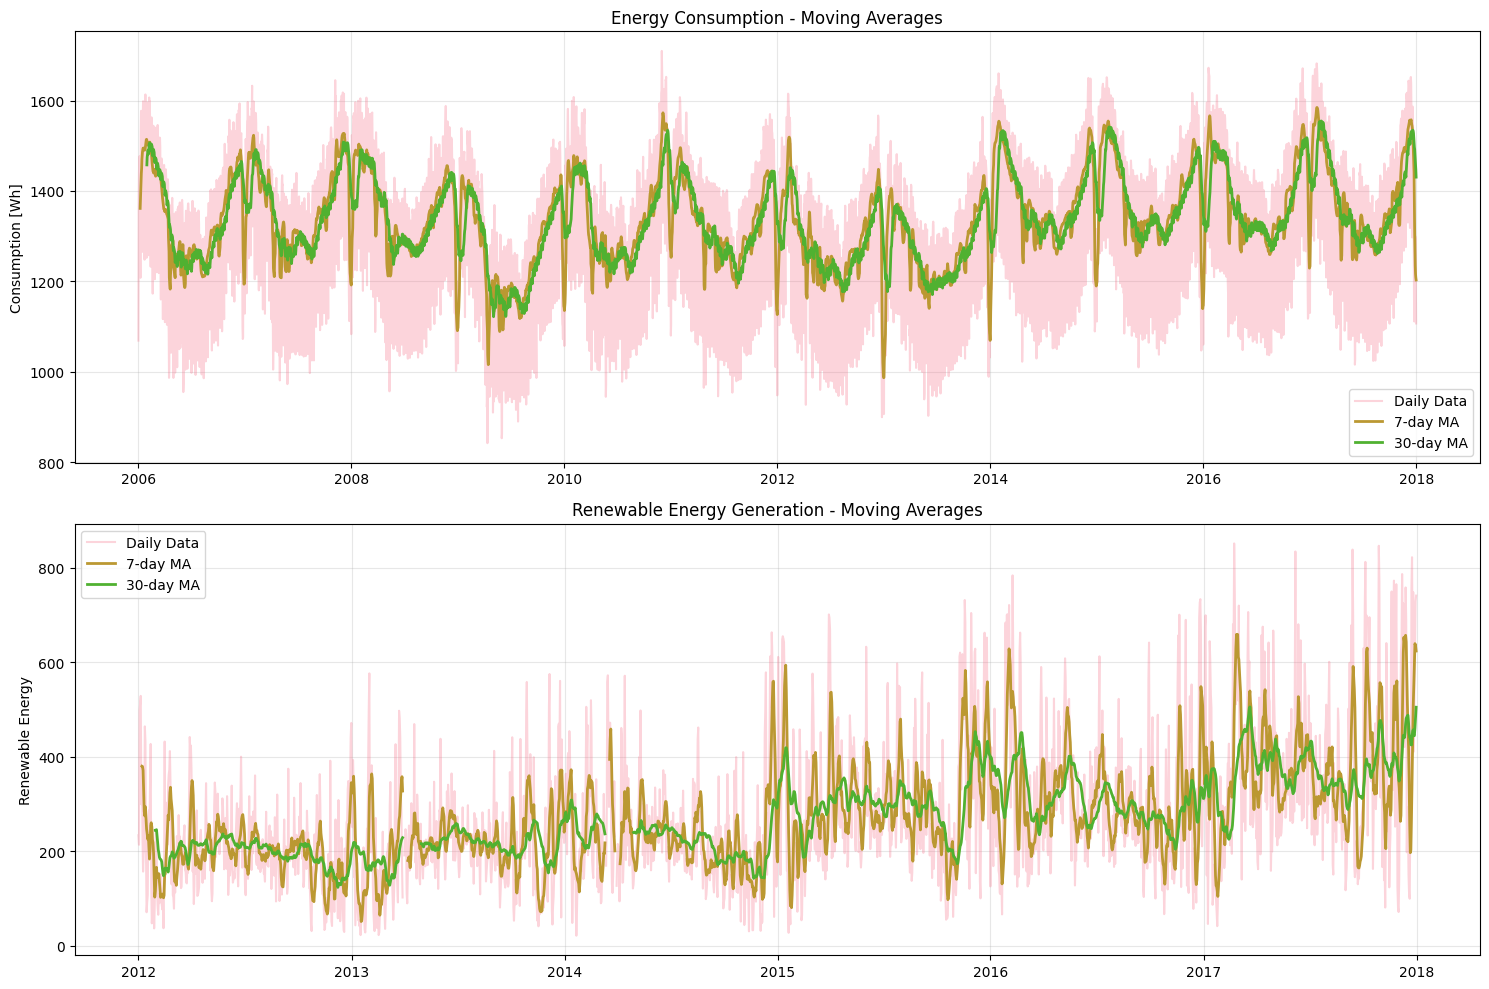

In [26]:
# Moving averages and trend analysis
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Energy consumption trends
df['consumption_ma7'] = df['consumption__wh_'].rolling(window=7).mean()
df['consumption_ma30'] = df['consumption__wh_'].rolling(window=30).mean()

axes[0].plot(df.index, df['consumption__wh_'], alpha=0.3, label='Daily Data')
axes[0].plot(df.index, df['consumption_ma7'], linewidth=2, label='7-day MA')
axes[0].plot(df.index, df['consumption_ma30'], linewidth=2, label='30-day MA')
axes[0].set_title('Energy Consumption - Moving Averages')
axes[0].set_ylabel('Consumption [Wh]')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Renewable energy trends
df['renewable_total'] = df['wind'] + df['solar']
df['renewable_ma7'] = df['renewable_total'].rolling(window=7).mean()
df['renewable_ma30'] = df['renewable_total'].rolling(window=30).mean()

axes[1].plot(df.index, df['renewable_total'], alpha=0.3, label='Daily Data')
axes[1].plot(df.index, df['renewable_ma7'], linewidth=2, label='7-day MA')
axes[1].plot(df.index, df['renewable_ma30'], linewidth=2, label='30-day MA')
axes[1].set_title('Renewable Energy Generation - Moving Averages')
axes[1].set_ylabel('Renewable Energy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'moving_averages_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Summary and Key Insights

### Processing Pipeline Summary:

1. **Data Loading and Preprocessing**
   - Loaded energy consumption time series with renewable energy data
   - Converted date columns to datetime index with proper frequency
   - Standardized column names for consistency

2. **Frequency Conversion**
   - Original frequency: Daily (D)
   - Target frequency: Weekly (W)
   - Demonstrated time series resampling fundamentals

3. **Downsampling with Aggregation**
   - Applied 3-day aggregation using sum operation
   - Maintained data integrity with min_count parameter
   - Achieved significant data compression while preserving trends

4. **Upsampling with Interpolation**
   - Converted daily to 2-hourly data using polynomial interpolation
   - Applied energy conservation scaling to maintain physical consistency
   - Demonstrated advanced interpolation techniques

5. **Multi-Sensor Data Processing**
   - Transformed long-format sensor data to wide-format time series
   - Applied 10-second resampling with mean aggregation
   - Used linear interpolation to handle missing values

### Key Technical Insights:

#### Time Series Resampling:
- **Downsampling**: Reduces data volume while preserving aggregate patterns
- **Upsampling**: Increases temporal resolution through intelligent interpolation
- **Frequency Alignment**: Critical for combining multiple time series

#### Interpolation Methods:
- **Linear**: Simple and efficient for smooth data
- **Polynomial**: Better for complex patterns, used 3rd order
- **Energy Conservation**: Scaling ensures physical laws are maintained

#### Data Quality Management:
- **Missing Data Handling**: Systematic approach using interpolation
- **Outlier Detection**: Through statistical analysis and visualization
- **Validation**: Cross-checking processed data against originals

### Applications and Use Cases:

1. **Energy Management**: Optimizing consumption patterns and renewable integration
2. **IoT Sensor Networks**: Processing irregular sensor measurements
3. **Data Pipeline Design**: Template for production time series processing
4. **Research Applications**: Standardized preprocessing for analysis

### Best Practices Demonstrated:

1. **Parameterized Processing**: Configuration-driven approach for flexibility
2. **Multiple Output Formats**: Both pickle and CSV for different use cases
3. **Quality Validation**: Statistical checks and visualizations
4. **Documentation**: Clear naming and comprehensive analysis

### Future Extensions:

- **Automated Quality Control**: Statistical tests for processed data
- **Advanced Interpolation**: Machine learning-based gap filling
- **Real-time Processing**: Streaming data pipeline implementation
- **Forecasting Integration**: Predictive models using processed data